In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from skimage.transform import resize

import os

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-12-05 13:12:08--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  28.5MB/s    in 12s     

2019-12-05 13:12:20 (19.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!unzip tiny-imagenet-200.zip &> log

In [0]:
num_classes = 20
wnids_file = os.path.join("tiny-imagenet-200", 'wnids.txt')
with open(wnids_file, 'r') as f:
    wnids = [x.strip() for x in f]

wnids = wnids[:num_classes]
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

In [0]:
X_train = []
y_train = []
for i, wnid in enumerate(wnids):
    boxes_file = os.path.join("tiny-imagenet-200", 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
        filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 64, 64, 3), dtype=np.int64)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
        img_file = os.path.join("tiny-imagenet-200", 'train', wnid, 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_train_block[j] = img

    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [0]:
indeces = np.arange(len(X_train))
np.random.shuffle(indeces)
X_train = np.resize(X_train[indeces], (len(indeces), 64, 64, 3)) / 255.
y_train = np.resize(y_train[indeces], (len(indeces),))

Class : 15


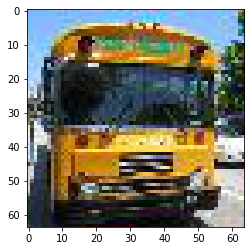


Class : 6


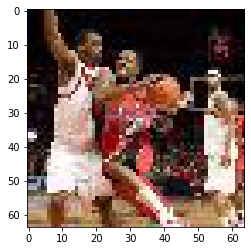


Class : 11


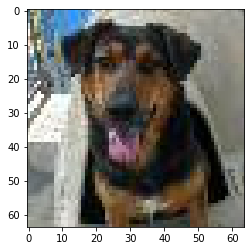


Class : 11


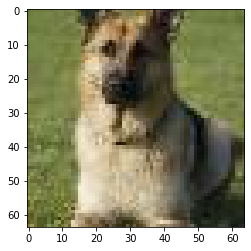


Class : 19


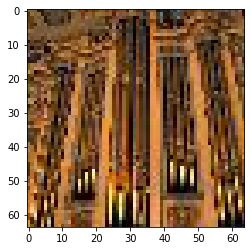

In [8]:
for i in range(5):
    print("Class :", y_train[i])
    plt.imshow(X_train[i])
    plt.show()
    print()

In [0]:
with open(os.path.join("tiny-imagenet-200", 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
        if line.split()[1] in wnids:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    X_val = np.zeros((num_val, 64, 64, 3), dtype=np.int64)
 
    for i, img_file in enumerate(img_files):
        img_file = os.path.join("tiny-imagenet-200", 'val', 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_val[i] = img

In [0]:
indeces = np.arange(len(X_val))
np.random.shuffle(indeces)
X_val = np.resize(X_val[indeces], (len(indeces), 64, 64, 3)) / 255.
y_val = np.resize(y_val[indeces], (len(indeces),))

In [11]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
pool = L.GlobalAveragePooling2D()(resnet_model.output)
dense = L.Dense(20, activation='softmax')(pool)
new_model = keras.models.Model(resnet_model.input, dense)
for l in resnet_model.layers:
    l.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
adam = keras.optimizers.Adam()
new_model.compile(optimizer=adam, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr_light.hdf5", 
                                               monitor="val_sparse_categorical_accuracy",
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=4, 
                                             verbose=1)

new_model.fit(X_train, y_train,
              batch_size=32, epochs=20, 
              validation_data=(X_val, y_val), 
              callbacks=[earlystopper, checkpointer])

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
 9984/10000 [============================>.] - ETA: 0s - loss: 1.7906 - sparse_categorical_accuracy: 0.5087
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.05000, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr_light.hdf5
10000/10000 [==============================] - 26s 3ms/sample - loss: 1.7895 - sparse_categorical_accuracy: 0.5089 - val_loss: 10.2013 - val_sparse_categorical_accuracy: 0.0500
Epoch 2/20
 9984/10000 [============================>.] - ETA: 0s - loss: 1.0694 - sparse_categorical_accuracy: 0.6759
Epoch 00002: val_sparse_categorical_accuracy improved from 0.05000 to 0.07500, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr_light.hdf5
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.0690 - sparse_categorical_accuracy: 0.6759 - val_loss: 4.7305 - val_sparse_categorical_accuracy: 0.0750
Epoch 3/20
 9984/10000 [===================

In [0]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
pool = L.GlobalAveragePooling2D()(resnet_model.output)
dense1 = L.Dense(512, activation="relu")(pool)
drop = L.Dropout(0.2)(dense1)
dense = L.Dense(20, activation='softmax')(drop)
new_model = keras.models.Model(resnet_model.input, dense)
for l in resnet_model.layers:
    l.trainable = True

In [0]:
adam = keras.optimizers.Adam()
new_model.compile(optimizer=adam, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr.hdf5", 
                                               monitor="val_sparse_categorical_accuracy",
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=5, 
                                             verbose=1)

new_model.fit(X_train, y_train,
              batch_size=32, epochs=30, 
              validation_data=(X_val, y_val), 
              callbacks=[earlystopper, checkpointer])

Train on 10000 samples, validate on 1000 samples
Epoch 1/30
 9952/10000 [============================>.] - ETA: 0s - loss: 1.8252 - sparse_categorical_accuracy: 0.4907
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.05000, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr.hdf5
10000/10000 [==============================] - 25s 3ms/sample - loss: 1.8231 - sparse_categorical_accuracy: 0.4910 - val_loss: 6.2007 - val_sparse_categorical_accuracy: 0.0500
Epoch 2/30
 9952/10000 [============================>.] - ETA: 0s - loss: 1.2310 - sparse_categorical_accuracy: 0.6353
Epoch 00002: val_sparse_categorical_accuracy improved from 0.05000 to 0.11800, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr.hdf5
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.2299 - sparse_categorical_accuracy: 0.6356 - val_loss: 3.2031 - val_sparse_categorical_accuracy: 0.1180
Epoch 3/30
 9952/10000 [============================>.] 

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen.fit(X_val)

In [0]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
pool = L.GlobalAveragePooling2D()(resnet_model.output)
dense = L.Dense(20, activation='softmax')(pool)
new_model = keras.models.Model(resnet_model.input, dense)
for l in resnet_model.layers:
    l.trainable = True

In [0]:
adam = keras.optimizers.Adam()
new_model.compile(optimizer=adam, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Colab Notebooks/tiny_imagenet_with_prepr.hdf5", 
                                               monitor="val_sparse_categorical_accuracy",
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=5, 
                                             verbose=1)

new_model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=30,
                        validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                        callbacks=[earlystopper, checkpointer])

Epoch 1/30
312/312 [============================>.] - ETA: 0s - loss: 2.8620 - sparse_categorical_accuracy: 0.3099
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.13200, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_with_prepr.hdf5
313/312 [==============================] - 71s 226ms/step - loss: 2.8606 - sparse_categorical_accuracy: 0.3101 - val_loss: 4.2795 - val_sparse_categorical_accuracy: 0.1320
Epoch 2/30
312/312 [============================>.] - ETA: 0s - loss: 2.8356 - sparse_categorical_accuracy: 0.2887
Epoch 00002: val_sparse_categorical_accuracy improved from 0.13200 to 0.20500, saving model to drive/My Drive/Colab Notebooks/tiny_imagenet_with_prepr.hdf5
313/312 [==============================] - 70s 224ms/step - loss: 2.8342 - sparse_categorical_accuracy: 0.2893 - val_loss: 7.8206 - val_sparse_categorical_accuracy: 0.2050
Epoch 3/30
312/312 [============================>.] - ETA: 0s - loss: 2.3122 - sparse_categorical_accuracy: 0.4134
Ep

In [0]:
new_model.load_weights("drive/My Drive/Colab Notebooks/tiny_imagenet_wo_prepr_light.hdf5")

In [0]:
def choose_images():
    att_i, ch_i = np.random.randint(len(X_val), size=2)

    attacked_img = X_val[att_i]
    changed_img = X_val[ch_i]

    attacked_img = tf.cast(tf.reshape(attacked_img, [1, *attacked_img.shape]), tf.float32)
    changed_img = tf.cast(tf.reshape(changed_img, [1, *changed_img.shape]), tf.float32)

    print("Attacked image: ")
    print("Logits: ", new_model(attacked_img).numpy()[0])
    print("Predicted: ", np.argmax(new_model(attacked_img)[0]))
    print("Real: ", y_val[att_i])
    plt.imshow(attacked_img[0])
    plt.show()

    print("Changing image: ")
    print("Logits: ", new_model(changed_img).numpy()[0])
    print("Predicted: ", np.argmax(new_model(changed_img)[0]))
    print("Real: ", y_val[ch_i])
    plt.imshow(changed_img[0])
    plt.show()
    
    return att_i, attacked_img, ch_i, changed_img

In [0]:
def attack(attacked_img, changed_img, eps=1, fn=tf.identity, iterations=40):  
    y = new_model(attacked_img)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(changed_img)
            y_pred = new_model(changed_img)
            loss = tf.reduce_mean((y - y_pred) ** 2)

        gradients, = tape.gradient(loss, changed_img)
        
        changed_img = tf.clip_by_value(changed_img - eps * fn(gradients), 0, 1)
        if i % 10 == 0:
            print("Loss : ", loss.numpy())
            print("Predict of changing image: ", np.argmax(y_pred[0]))
            print("Logits of changing image: ", y_pred.numpy()[0])
            print("Logits of attacked image: ", y.numpy()[0])
            plt.imshow(changed_img[0, :])
            plt.show()


Attacked image: 
Logits:  [0.00073202 0.06758855 0.07976086 0.00088671 0.51397884 0.22724117
 0.00146516 0.00164369 0.0160348  0.00519117 0.00532327 0.0017648
 0.00567808 0.00331238 0.00161394 0.03327179 0.00115689 0.00406535
 0.02876077 0.00052979]
Predicted:  4
Real:  4


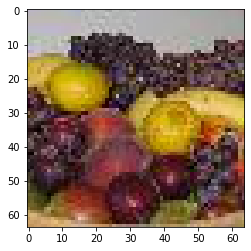

Changing image: 
Logits:  [9.8927049e-03 1.2636017e-02 1.5659359e-03 2.3369779e-01 2.9775285e-04
 7.4402307e-04 5.4162681e-02 4.8887752e-05 2.8415476e-03 1.8755665e-02
 1.1848593e-02 5.0201663e-03 5.6894455e-02 1.1585135e-03 7.2058886e-03
 9.1317372e-04 1.2054956e-03 3.3359751e-03 1.3411552e-01 4.4365922e-01]
Predicted:  19
Real:  19


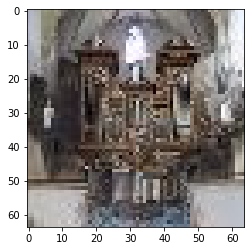

In [17]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.029647458
Predict of changing image:  19
Logits of changing image:  [9.8927049e-03 1.2636017e-02 1.5659359e-03 2.3369779e-01 2.9775285e-04
 7.4402307e-04 5.4162681e-02 4.8887752e-05 2.8415476e-03 1.8755665e-02
 1.1848593e-02 5.0201663e-03 5.6894455e-02 1.1585135e-03 7.2058886e-03
 9.1317372e-04 1.2054956e-03 3.3359751e-03 1.3411552e-01 4.4365922e-01]
Logits of attacked image:  [0.00073202 0.06758855 0.07976086 0.00088671 0.51397884 0.22724117
 0.00146516 0.00164369 0.0160348  0.00519117 0.00532327 0.0017648
 0.00567808 0.00331238 0.00161394 0.03327179 0.00115689 0.00406535
 0.02876077 0.00052979]


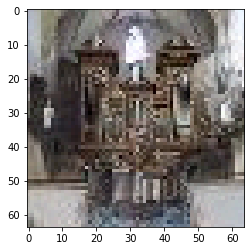

Loss :  0.008463228
Predict of changing image:  5
Logits of changing image:  [0.02534605 0.02817739 0.00727112 0.03558991 0.22947076 0.50547075
 0.00445406 0.00053589 0.01369443 0.00844726 0.0167329  0.00254021
 0.02776612 0.02429573 0.00264586 0.0178866  0.02610395 0.00711171
 0.01109937 0.00535993]
Logits of attacked image:  [0.00073202 0.06758855 0.07976086 0.00088671 0.51397884 0.22724117
 0.00146516 0.00164369 0.0160348  0.00519117 0.00532327 0.0017648
 0.00567808 0.00331238 0.00161394 0.03327179 0.00115689 0.00406535
 0.02876077 0.00052979]


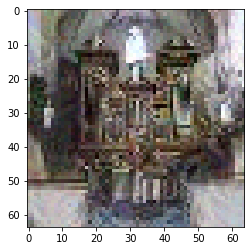

Loss :  0.005537659
Predict of changing image:  4
Logits of changing image:  [0.05281674 0.03203018 0.02491637 0.04299294 0.3137181  0.02732965
 0.03109845 0.00088198 0.06844392 0.03155032 0.02106237 0.0058695
 0.03820169 0.00888497 0.00286875 0.1303358  0.05493874 0.01072744
 0.03930968 0.06202244]
Logits of attacked image:  [0.00073202 0.06758855 0.07976086 0.00088671 0.51397884 0.22724117
 0.00146516 0.00164369 0.0160348  0.00519117 0.00532327 0.0017648
 0.00567808 0.00331238 0.00161394 0.03327179 0.00115689 0.00406535
 0.02876077 0.00052979]


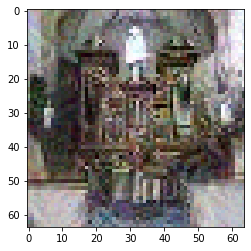

Loss :  0.007316926
Predict of changing image:  4
Logits of changing image:  [7.1677119e-03 1.0615668e-02 6.5536532e-03 1.2817878e-02 8.3843297e-01
 5.1334016e-02 6.8124593e-03 1.8078933e-04 7.0381849e-03 6.8851225e-03
 1.1036453e-02 8.9741946e-04 8.5137561e-03 4.6876264e-03 2.0773013e-04
 1.0382422e-02 7.9882834e-03 2.4582329e-03 4.2406037e-03 1.7490338e-03]
Logits of attacked image:  [0.00073202 0.06758855 0.07976086 0.00088671 0.51397884 0.22724117
 0.00146516 0.00164369 0.0160348  0.00519117 0.00532327 0.0017648
 0.00567808 0.00331238 0.00161394 0.03327179 0.00115689 0.00406535
 0.02876077 0.00052979]


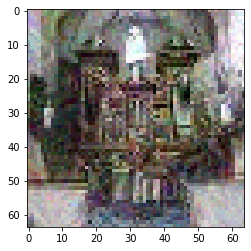

In [23]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [5.4545580e-05 3.2228287e-04 7.4336659e-03 1.4027682e-04 1.1771845e-05
 7.1403592e-06 2.7534026e-03 3.5969148e-05 3.2085777e-06 1.0926288e-02
 8.1723709e-05 2.6557941e-03 6.2122654e-06 5.1600826e-05 5.0456403e-03
 1.9675137e-05 1.6171435e-06 1.7200554e-04 9.7025442e-01 2.2823124e-05]
Predicted:  18
Real:  18


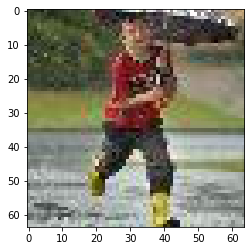

Changing image: 
Logits:  [1.81457517e-06 9.94219729e-09 1.18270810e-10 7.75707765e-09
 7.43894779e-10 4.54554687e-08 2.06001305e-09 1.43895855e-08
 2.80702239e-09 5.06654185e-09 1.64823752e-10 3.48786853e-06
 2.40397396e-10 3.46489781e-11 9.99993920e-01 1.23196786e-10
 4.55320420e-10 7.27551821e-07 1.03147704e-08 1.18880558e-10]
Predicted:  14
Real:  14


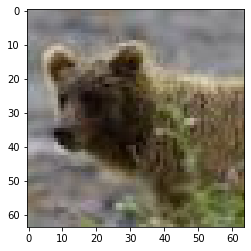

In [24]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.096575245
Predict of changing image:  14
Logits of changing image:  [1.81457517e-06 9.94219729e-09 1.18270810e-10 7.75707765e-09
 7.43894779e-10 4.54554687e-08 2.06001305e-09 1.43895855e-08
 2.80702239e-09 5.06654185e-09 1.64823752e-10 3.48786853e-06
 2.40397396e-10 3.46489781e-11 9.99993920e-01 1.23196786e-10
 4.55320420e-10 7.27551821e-07 1.03147704e-08 1.18880558e-10]
Logits of attacked image:  [5.4545580e-05 3.2228287e-04 7.4336659e-03 1.4027682e-04 1.1771845e-05
 7.1403592e-06 2.7534026e-03 3.5969148e-05 3.2085777e-06 1.0926288e-02
 8.1723709e-05 2.6557941e-03 6.2122654e-06 5.1600826e-05 5.0456403e-03
 1.9675137e-05 1.6171435e-06 1.7200554e-04 9.7025442e-01 2.2823124e-05]


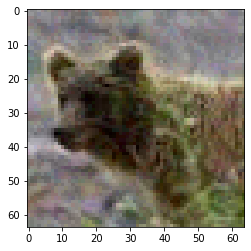

Loss :  0.06853517
Predict of changing image:  10
Logits of changing image:  [4.01807682e-07 6.64575433e-04 1.30512388e-04 4.38312418e-06
 1.56280730e-05 5.29158456e-07 1.65804122e-02 1.02549915e-08
 1.83854776e-04 3.33395496e-06 8.33097160e-01 1.20554205e-06
 1.35611463e-05 3.26391415e-07 2.23093906e-07 1.88556933e-05
 5.92861397e-06 6.81752226e-06 1.47824854e-01 1.44736061e-03]
Logits of attacked image:  [5.4545580e-05 3.2228287e-04 7.4336659e-03 1.4027682e-04 1.1771845e-05
 7.1403592e-06 2.7534026e-03 3.5969148e-05 3.2085777e-06 1.0926288e-02
 8.1723709e-05 2.6557941e-03 6.2122654e-06 5.1600826e-05 5.0456403e-03
 1.9675137e-05 1.6171435e-06 1.7200554e-04 9.7025442e-01 2.2823124e-05]


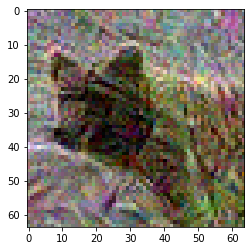

Loss :  1.8627823e-05
Predict of changing image:  18
Logits of changing image:  [1.4455142e-06 9.2528267e-03 4.4100094e-04 1.5829915e-05 1.7804392e-04
 8.3630939e-06 1.1025877e-02 2.1102062e-06 4.3642111e-05 6.9711234e-05
 2.0126805e-03 5.6041663e-06 4.3977518e-05 2.3488086e-04 3.6370036e-06
 1.7339984e-04 4.3852131e-05 1.6356991e-05 9.7442222e-01 2.0046341e-03]
Logits of attacked image:  [5.4545580e-05 3.2228287e-04 7.4336659e-03 1.4027682e-04 1.1771845e-05
 7.1403592e-06 2.7534026e-03 3.5969148e-05 3.2085777e-06 1.0926288e-02
 8.1723709e-05 2.6557941e-03 6.2122654e-06 5.1600826e-05 5.0456403e-03
 1.9675137e-05 1.6171435e-06 1.7200554e-04 9.7025442e-01 2.2823124e-05]


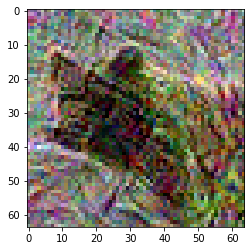

Loss :  0.00025342064
Predict of changing image:  18
Logits of changing image:  [5.6734054e-05 1.3620233e-02 3.4194058e-03 7.3757977e-04 3.2202753e-03
 1.0798860e-04 3.2953613e-02 5.6637884e-05 9.3390245e-04 1.1973456e-03
 7.9017002e-03 9.6792508e-05 5.8463268e-04 1.4126352e-03 8.4646599e-05
 2.6419880e-03 8.5106242e-04 3.2050893e-04 9.1170245e-01 1.8099833e-02]
Logits of attacked image:  [5.4545580e-05 3.2228287e-04 7.4336659e-03 1.4027682e-04 1.1771845e-05
 7.1403592e-06 2.7534026e-03 3.5969148e-05 3.2085777e-06 1.0926288e-02
 8.1723709e-05 2.6557941e-03 6.2122654e-06 5.1600826e-05 5.0456403e-03
 1.9675137e-05 1.6171435e-06 1.7200554e-04 9.7025442e-01 2.2823124e-05]


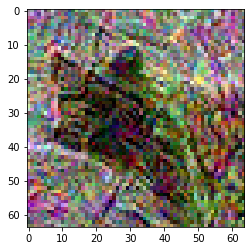

In [29]:
attack(attacked_img, changed_img, eps=0.03, fn=tf.sign, iterations=40)

Attacked image: 
Logits:  [4.6193693e-07 1.9179083e-06 4.6286695e-07 1.0205657e-05 2.9253937e-07
 1.3629004e-07 4.6382848e-07 2.3270138e-08 9.9756420e-01 7.0743346e-07
 8.3064479e-05 6.8425017e-08 2.4454505e-06 3.2629728e-06 4.3879481e-07
 8.8758776e-07 1.8741717e-04 2.6773168e-06 7.0283379e-05 2.0707271e-03]
Predicted:  8
Real:  8


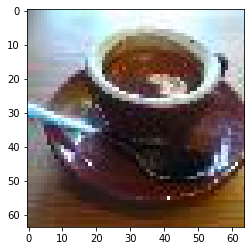

Changing image: 
Logits:  [4.4856425e-02 1.2573117e-02 3.7349317e-02 5.3701317e-04 9.3548521e-03
 2.5370687e-03 3.4574669e-02 2.3116856e-03 2.6113654e-03 9.2328750e-02
 3.3292652e-04 6.8140221e-01 2.8698542e-03 1.5015752e-02 1.2693687e-03
 4.8085154e-04 3.1833086e-02 2.0572076e-02 6.4623933e-03 7.2707504e-04]
Predicted:  11
Real:  11


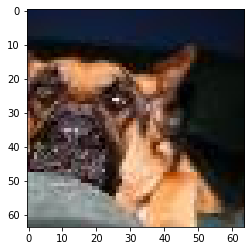

In [38]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.07346636
Predict of changing image:  11
Logits of changing image:  [4.4856425e-02 1.2573117e-02 3.7349317e-02 5.3701317e-04 9.3548521e-03
 2.5370687e-03 3.4574669e-02 2.3116856e-03 2.6113654e-03 9.2328750e-02
 3.3292652e-04 6.8140221e-01 2.8698542e-03 1.5015752e-02 1.2693687e-03
 4.8085154e-04 3.1833086e-02 2.0572076e-02 6.4623933e-03 7.2707504e-04]
Logits of attacked image:  [4.6193693e-07 1.9179083e-06 4.6286695e-07 1.0205657e-05 2.9253937e-07
 1.3629004e-07 4.6382848e-07 2.3270138e-08 9.9756420e-01 7.0743346e-07
 8.3064479e-05 6.8425017e-08 2.4454505e-06 3.2629728e-06 4.3879481e-07
 8.8758776e-07 1.8741717e-04 2.6773168e-06 7.0283379e-05 2.0707271e-03]


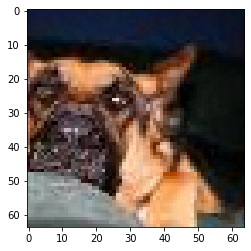

Loss :  1.4529902e-06
Predict of changing image:  8
Logits of changing image:  [1.9826539e-04 6.7605171e-04 5.1307994e-05 9.8434703e-06 1.7720987e-03
 2.4785952e-05 1.0959848e-03 3.8548635e-07 9.9336892e-01 2.6115784e-04
 1.1854540e-05 2.5296176e-05 9.3112292e-05 1.8711461e-06 9.3591934e-06
 2.1476899e-05 1.3669741e-03 9.7947975e-04 8.4662106e-06 2.3372279e-05]
Logits of attacked image:  [4.6193693e-07 1.9179083e-06 4.6286695e-07 1.0205657e-05 2.9253937e-07
 1.3629004e-07 4.6382848e-07 2.3270138e-08 9.9756420e-01 7.0743346e-07
 8.3064479e-05 6.8425017e-08 2.4454505e-06 3.2629728e-06 4.3879481e-07
 8.8758776e-07 1.8741717e-04 2.6773168e-06 7.0283379e-05 2.0707271e-03]


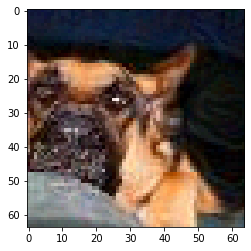

Loss :  4.1176355e-07
Predict of changing image:  8
Logits of changing image:  [4.3892775e-05 4.6325888e-05 1.4838414e-06 1.1585134e-06 1.0286379e-04
 1.0557079e-06 4.8183345e-05 1.0099270e-08 9.9953496e-01 1.1021712e-05
 1.6451449e-06 1.3471122e-06 7.9216243e-06 4.6985260e-08 8.3951926e-07
 2.1699104e-06 4.6482019e-05 1.4708191e-04 2.6693394e-07 1.3774663e-06]
Logits of attacked image:  [4.6193693e-07 1.9179083e-06 4.6286695e-07 1.0205657e-05 2.9253937e-07
 1.3629004e-07 4.6382848e-07 2.3270138e-08 9.9756420e-01 7.0743346e-07
 8.3064479e-05 6.8425017e-08 2.4454505e-06 3.2629728e-06 4.3879481e-07
 8.8758776e-07 1.8741717e-04 2.6773168e-06 7.0283379e-05 2.0707271e-03]


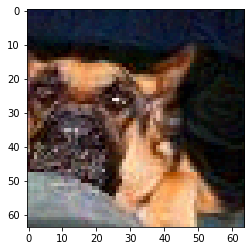

Loss :  2.5701587e-07
Predict of changing image:  8
Logits of changing image:  [1.5740698e-04 1.6792628e-04 1.9130903e-05 8.2349507e-06 5.4673862e-04
 4.0027039e-06 5.0420326e-04 8.0910603e-08 9.9771833e-01 1.4775696e-04
 7.5720304e-06 8.2311908e-06 3.6232374e-05 5.4781867e-07 3.3326485e-06
 1.3313074e-05 1.1112203e-04 5.2225514e-04 2.9259056e-06 2.0696843e-05]
Logits of attacked image:  [4.6193693e-07 1.9179083e-06 4.6286695e-07 1.0205657e-05 2.9253937e-07
 1.3629004e-07 4.6382848e-07 2.3270138e-08 9.9756420e-01 7.0743346e-07
 8.3064479e-05 6.8425017e-08 2.4454505e-06 3.2629728e-06 4.3879481e-07
 8.8758776e-07 1.8741717e-04 2.6773168e-06 7.0283379e-05 2.0707271e-03]


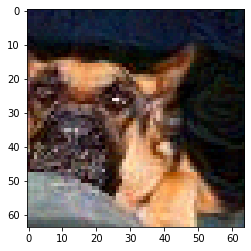

In [40]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)

Attacked image: 
Logits:  [3.89955481e-08 4.45149283e-07 6.81846846e-09 9.29199739e-09
 1.96069308e-07 1.06792231e-05 3.18587155e-07 2.10484899e-07
 8.90179672e-06 8.46331805e-09 3.20327631e-09 2.15778087e-07
 5.08547373e-06 4.21830606e-08 1.40906735e-07 3.19817861e-09
 9.99973178e-01 4.07937591e-07 1.12100274e-07 1.85668492e-09]
Predicted:  16
Real:  16


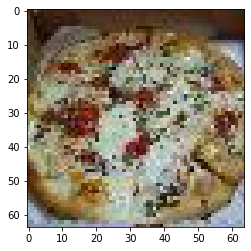

Changing image: 
Logits:  [1.9063520e-04 7.9824356e-04 4.2283640e-04 9.3013622e-02 1.2320459e-05
 1.9535084e-05 2.4716491e-03 4.2599546e-05 7.3873001e-05 8.0793106e-04
 3.1105699e-03 1.3999901e-04 8.8680083e-01 1.5334317e-05 3.9971333e-06
 1.6342135e-04 9.2872215e-05 8.1954277e-05 6.9260006e-03 4.8117712e-03]
Predicted:  12
Real:  12


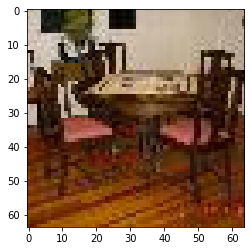

In [42]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.089745365
Predict of changing image:  12
Logits of changing image:  [1.9063520e-04 7.9824356e-04 4.2283640e-04 9.3013622e-02 1.2320459e-05
 1.9535084e-05 2.4716491e-03 4.2599546e-05 7.3873001e-05 8.0793106e-04
 3.1105699e-03 1.3999901e-04 8.8680083e-01 1.5334317e-05 3.9971333e-06
 1.6342135e-04 9.2872215e-05 8.1954277e-05 6.9260006e-03 4.8117712e-03]
Logits of attacked image:  [3.89955481e-08 4.45149283e-07 6.81846846e-09 9.29199739e-09
 1.96069308e-07 1.06792231e-05 3.18587155e-07 2.10484899e-07
 8.90179672e-06 8.46331805e-09 3.20327631e-09 2.15778087e-07
 5.08547373e-06 4.21830606e-08 1.40906735e-07 3.19817861e-09
 9.99973178e-01 4.07937591e-07 1.12100274e-07 1.85668492e-09]


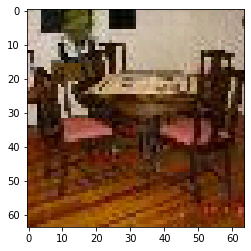

Loss :  1.462096e-11
Predict of changing image:  16
Logits of changing image:  [3.3601726e-08 1.9203785e-06 3.1010085e-08 2.9656926e-08 7.1496093e-09
 2.8042462e-06 1.5706200e-06 2.2772044e-06 1.3748823e-06 4.6224700e-09
 2.2217466e-09 2.1665112e-06 7.5496422e-07 5.1278651e-08 6.3500657e-08
 7.5901099e-08 9.9998510e-01 1.3703478e-06 4.1662526e-07 5.2620468e-09]
Logits of attacked image:  [3.89955481e-08 4.45149283e-07 6.81846846e-09 9.29199739e-09
 1.96069308e-07 1.06792231e-05 3.18587155e-07 2.10484899e-07
 8.90179672e-06 8.46331805e-09 3.20327631e-09 2.15778087e-07
 5.08547373e-06 4.21830606e-08 1.40906735e-07 3.19817861e-09
 9.99973178e-01 4.07937591e-07 1.12100274e-07 1.85668492e-09]


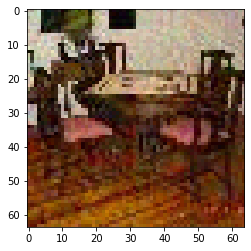

Loss :  2.1820153e-08
Predict of changing image:  16
Logits of changing image:  [4.4306453e-06 4.6823079e-05 2.4367748e-06 1.3689687e-05 1.8502608e-06
 1.7343542e-04 5.3474654e-05 3.3145017e-05 6.5267253e-05 8.2356013e-07
 1.0241291e-06 4.4076369e-05 5.9741826e-05 3.7523803e-06 2.9563055e-06
 8.7693143e-06 9.9935263e-01 9.8953788e-05 2.4542325e-05 8.1234339e-06]
Logits of attacked image:  [3.89955481e-08 4.45149283e-07 6.81846846e-09 9.29199739e-09
 1.96069308e-07 1.06792231e-05 3.18587155e-07 2.10484899e-07
 8.90179672e-06 8.46331805e-09 3.20327631e-09 2.15778087e-07
 5.08547373e-06 4.21830606e-08 1.40906735e-07 3.19817861e-09
 9.99973178e-01 4.07937591e-07 1.12100274e-07 1.85668492e-09]


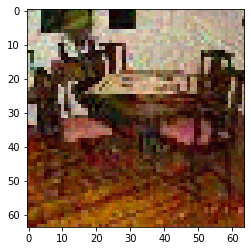

Loss :  1.2469285e-11
Predict of changing image:  16
Logits of changing image:  [3.7356916e-08 1.3302184e-06 2.1247891e-08 1.2509159e-08 1.7915363e-08
 6.7554965e-06 8.9553288e-07 6.7367392e-07 2.0499990e-06 2.5282052e-09
 2.6138030e-09 6.7252819e-07 3.3649135e-07 6.2470797e-08 5.2001145e-08
 2.9001406e-08 9.9998593e-01 7.6138775e-07 4.0320433e-07 4.9121391e-09]
Logits of attacked image:  [3.89955481e-08 4.45149283e-07 6.81846846e-09 9.29199739e-09
 1.96069308e-07 1.06792231e-05 3.18587155e-07 2.10484899e-07
 8.90179672e-06 8.46331805e-09 3.20327631e-09 2.15778087e-07
 5.08547373e-06 4.21830606e-08 1.40906735e-07 3.19817861e-09
 9.99973178e-01 4.07937591e-07 1.12100274e-07 1.85668492e-09]


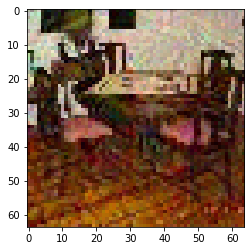

In [43]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [3.84286759e-13 2.45166065e-09 1.54433463e-11 1.77756559e-11
 1.74246869e-12 6.61402183e-12 4.67717770e-13 1.33346728e-11
 1.10386500e-11 3.22496652e-12 1.07003029e-09 1.77879155e-13
 3.42859664e-11 9.99999762e-01 2.32282607e-15 8.30530577e-13
 3.51246476e-09 1.35859375e-14 2.23374684e-07 7.56159135e-09]
Predicted:  13
Real:  13


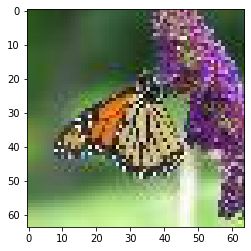

Changing image: 
Logits:  [2.2507264e-04 1.0241556e-02 4.5946883e-03 9.4056642e-01 1.3045555e-03
 1.6541295e-03 5.0628600e-03 3.4486067e-05 1.0920388e-04 1.3659055e-03
 1.3380853e-02 7.6349051e-04 9.2895431e-03 1.3703821e-04 1.3394743e-05
 1.3887524e-03 1.9030136e-04 7.2628391e-05 9.2721209e-03 3.3303699e-04]
Predicted:  3
Real:  3


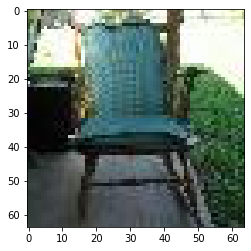

In [44]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.094245136
Predict of changing image:  3
Logits of changing image:  [2.2507264e-04 1.0241556e-02 4.5946883e-03 9.4056642e-01 1.3045555e-03
 1.6541295e-03 5.0628600e-03 3.4486067e-05 1.0920388e-04 1.3659055e-03
 1.3380853e-02 7.6349051e-04 9.2895431e-03 1.3703821e-04 1.3394743e-05
 1.3887524e-03 1.9030136e-04 7.2628391e-05 9.2721209e-03 3.3303699e-04]
Logits of attacked image:  [3.84286759e-13 2.45166065e-09 1.54433463e-11 1.77756559e-11
 1.74246869e-12 6.61402183e-12 4.67717770e-13 1.33346728e-11
 1.10386500e-11 3.22496652e-12 1.07003029e-09 1.77879155e-13
 3.42859664e-11 9.99999762e-01 2.32282607e-15 8.30530577e-13
 3.51246476e-09 1.35859375e-14 2.23374684e-07 7.56159135e-09]


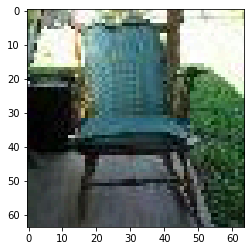

Loss :  0.05299478
Predict of changing image:  6
Logits of changing image:  [0.01348332 0.08387858 0.08265874 0.10628303 0.0406281  0.03013626
 0.14091061 0.00632759 0.06679353 0.04041907 0.06566687 0.01940117
 0.07047279 0.00754161 0.00946238 0.05905811 0.02385019 0.0156046
 0.0653403  0.05208315]
Logits of attacked image:  [3.84286759e-13 2.45166065e-09 1.54433463e-11 1.77756559e-11
 1.74246869e-12 6.61402183e-12 4.67717770e-13 1.33346728e-11
 1.10386500e-11 3.22496652e-12 1.07003029e-09 1.77879155e-13
 3.42859664e-11 9.99999762e-01 2.32282607e-15 8.30530577e-13
 3.51246476e-09 1.35859375e-14 2.23374684e-07 7.56159135e-09]


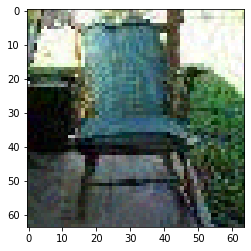

Loss :  5.2268425e-15
Predict of changing image:  13
Logits of changing image:  [3.5568681e-12 2.2562565e-08 2.6472741e-10 3.0279819e-12 2.1713545e-10
 1.4498078e-08 1.7748581e-12 1.1682631e-10 6.0667686e-11 4.3276493e-12
 3.1460851e-10 1.6394448e-12 7.4300274e-11 1.0000000e+00 2.9534966e-13
 1.6549430e-12 2.2054738e-09 1.4117406e-12 6.4884578e-09 1.4834808e-09]
Logits of attacked image:  [3.84286759e-13 2.45166065e-09 1.54433463e-11 1.77756559e-11
 1.74246869e-12 6.61402183e-12 4.67717770e-13 1.33346728e-11
 1.10386500e-11 3.22496652e-12 1.07003029e-09 1.77879155e-13
 3.42859664e-11 9.99999762e-01 2.32282607e-15 8.30530577e-13
 3.51246476e-09 1.35859375e-14 2.23374684e-07 7.56159135e-09]


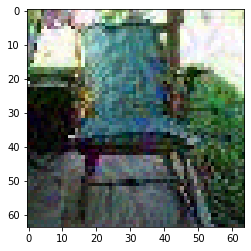

Loss :  3.1193113e-15
Predict of changing image:  13
Logits of changing image:  [3.9765114e-12 5.2177600e-09 4.6103822e-11 4.6070925e-12 1.3323317e-10
 2.5805411e-09 1.0493826e-12 9.4182655e-11 1.6613047e-10 2.7043745e-12
 1.6507831e-10 1.1431272e-12 1.2247052e-10 9.9999988e-01 3.0409448e-13
 3.2170111e-12 3.7419053e-08 6.1617698e-13 6.8808124e-09 1.9434422e-08]
Logits of attacked image:  [3.84286759e-13 2.45166065e-09 1.54433463e-11 1.77756559e-11
 1.74246869e-12 6.61402183e-12 4.67717770e-13 1.33346728e-11
 1.10386500e-11 3.22496652e-12 1.07003029e-09 1.77879155e-13
 3.42859664e-11 9.99999762e-01 2.32282607e-15 8.30530577e-13
 3.51246476e-09 1.35859375e-14 2.23374684e-07 7.56159135e-09]


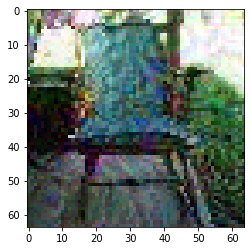

In [45]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [3.6574057e-03 5.8445823e-01 7.2434871e-04 1.0903612e-02 4.7489043e-04
 1.2931828e-02 5.9062021e-04 7.3003896e-02 7.5936428e-04 1.8290483e-03
 4.3989282e-02 8.5073765e-03 4.2901840e-03 1.0184376e-04 1.7300031e-01
 3.6726431e-03 4.1659363e-04 4.5833824e-04 7.4498095e-02 1.7320267e-03]
Predicted:  1
Real:  1


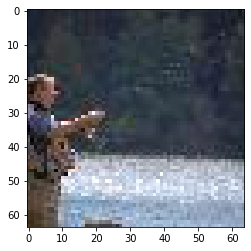

Changing image: 
Logits:  [8.3824020e-08 4.9819587e-08 4.6577182e-09 3.6861084e-07 4.1723096e-09
 2.6658876e-08 8.4878415e-09 1.0375484e-09 9.9975199e-01 4.7886703e-09
 4.3673510e-05 3.4202789e-09 2.1258941e-07 1.0510239e-07 1.2183691e-08
 1.6868277e-08 2.0387499e-05 1.1009447e-07 3.0028402e-06 1.7993903e-04]
Predicted:  8
Real:  8


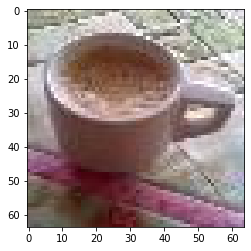

In [46]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.069136396
Predict of changing image:  8
Logits of changing image:  [8.3824020e-08 4.9819587e-08 4.6577182e-09 3.6861084e-07 4.1723096e-09
 2.6658876e-08 8.4878415e-09 1.0375484e-09 9.9975199e-01 4.7886703e-09
 4.3673510e-05 3.4202789e-09 2.1258941e-07 1.0510239e-07 1.2183691e-08
 1.6868277e-08 2.0387499e-05 1.1009447e-07 3.0028402e-06 1.7993903e-04]
Logits of attacked image:  [3.6574057e-03 5.8445823e-01 7.2434871e-04 1.0903612e-02 4.7489043e-04
 1.2931828e-02 5.9062021e-04 7.3003896e-02 7.5936428e-04 1.8290483e-03
 4.3989282e-02 8.5073765e-03 4.2901840e-03 1.0184376e-04 1.7300031e-01
 3.6726431e-03 4.1659363e-04 4.5833824e-04 7.4498095e-02 1.7320267e-03]


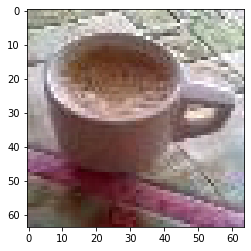

Loss :  0.005814238
Predict of changing image:  1
Logits of changing image:  [1.6282526e-04 8.6379594e-01 2.7727829e-02 6.3407193e-03 9.7842247e-05
 2.9521172e-03 1.7174462e-02 4.2718096e-04 2.1067932e-03 2.7940490e-03
 5.1848665e-03 1.4351141e-03 5.6416127e-03 3.1547350e-04 1.1831537e-03
 1.4652242e-03 1.9449600e-03 1.1326165e-03 4.8155855e-02 9.9613862e-03]
Logits of attacked image:  [3.6574057e-03 5.8445823e-01 7.2434871e-04 1.0903612e-02 4.7489043e-04
 1.2931828e-02 5.9062021e-04 7.3003896e-02 7.5936428e-04 1.8290483e-03
 4.3989282e-02 8.5073765e-03 4.2901840e-03 1.0184376e-04 1.7300031e-01
 3.6726431e-03 4.1659363e-04 4.5833824e-04 7.4498095e-02 1.7320267e-03]


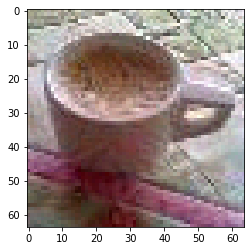

Loss :  0.003025736
Predict of changing image:  1
Logits of changing image:  [5.5751594e-04 7.3047310e-01 5.3257622e-02 1.5491866e-02 3.4169602e-04
 6.7866128e-03 3.2180749e-02 1.3806141e-03 5.7732021e-03 6.7801629e-03
 9.7650224e-03 4.1988445e-03 1.4153992e-02 9.0292661e-04 4.1370899e-03
 4.2556645e-03 6.4133112e-03 2.7422837e-03 8.1472211e-02 1.8935559e-02]
Logits of attacked image:  [3.6574057e-03 5.8445823e-01 7.2434871e-04 1.0903612e-02 4.7489043e-04
 1.2931828e-02 5.9062021e-04 7.3003896e-02 7.5936428e-04 1.8290483e-03
 4.3989282e-02 8.5073765e-03 4.2901840e-03 1.0184376e-04 1.7300031e-01
 3.6726431e-03 4.1659363e-04 4.5833824e-04 7.4498095e-02 1.7320267e-03]


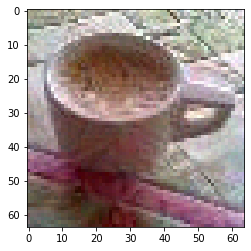

Loss :  0.0022396971
Predict of changing image:  1
Logits of changing image:  [1.0752038e-03 6.6482508e-01 5.0925136e-02 2.2355314e-02 5.6892703e-04
 1.0738536e-02 3.3526670e-02 2.7515201e-03 9.5786173e-03 9.7774789e-03
 1.3581541e-02 6.9889482e-03 1.8058745e-02 1.3341949e-03 8.2968511e-03
 7.2785965e-03 1.1287043e-02 3.8852603e-03 9.4682984e-02 2.8483257e-02]
Logits of attacked image:  [3.6574057e-03 5.8445823e-01 7.2434871e-04 1.0903612e-02 4.7489043e-04
 1.2931828e-02 5.9062021e-04 7.3003896e-02 7.5936428e-04 1.8290483e-03
 4.3989282e-02 8.5073765e-03 4.2901840e-03 1.0184376e-04 1.7300031e-01
 3.6726431e-03 4.1659363e-04 4.5833824e-04 7.4498095e-02 1.7320267e-03]


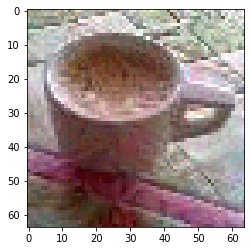

In [48]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)